In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import torch
from torch.autograd import grad

from clusterless import preprocess
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

### Data

In [4]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/'

In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [6]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, split=.8):
        
        self.train_ids = self.rand_trial_ids[:int(split * self.n_trials)]
        self.test_ids = self.rand_trial_ids[int(split * self.n_trials):]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_trial_ids, test_trial_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_trial_ids, train_t_ids, \
               test_trials, test_trial_ids, test_t_ids

In [7]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = wheel_velocity, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [8]:
train_trials, train_trial_ids, train_t_ids, _, _, _ = data_loader.split_train_test(split=.8)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
C = 10
gmm = GaussianMixture(n_components=C, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=0)
gmm.fit(train_trials)

GaussianMixture(init_params='k-means++', n_components=10)

### ELBO

In [10]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [11]:
def compute_elbo(s, r, mu, cov, log_norm_lam, k_idxs, t_idxs, K, T, C):

    # expected log-likelihood ( E_q(z)[log p(s,z|y)] )
    # sum_{ktij} r_{ijt}^k * log(dN(s_i^kt; mu_j, cov_j))
    
    # sum_{ktij} r_{ijt}^k * ( log(lambda_jt^(k)) - log(sum_j' lambda_j't^(k)) ) 
    elbo_1 = 0; log_dens = []
    for j in range(C):
        log_dens.append(
            torch.tensor(
                multivariate_normal.logpdf(s, mu[j], cov[j])
            )
        )
        elbo_1 += torch.einsum('i,i->', r[:,j], log_dens[-1])
      
    elbo_2 = torch.tensor([ 
                torch.sum( r[np.intersect1d(k_idxs[k], t_idxs[t])] * log_norm_lam[k,:,t] ) \
                for t in range(T) for k in range(K)
             ]).sum()
        
    # entropy of q(z) ( E_q(z)[log q(z)] )
    # sum_{ktij} log(r_{ijt}^k) * r_{ijt}^k
    elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)
    
    elbo = elbo_1 + elbo_2 + elbo_3 
    
    print(f'elbo 1: {elbo_1}')
    print(f'elbo 2: {elbo_2}')
    print(f'elbo 3: {elbo_3}')
    
    return elbo, torch.vstack(log_dens).T

In [12]:
K = len(data_loader.train_ids)
C = len(gmm.means_)
T = data_loader.n_t_bins

s = torch.tensor(train_trials)
r = torch.ones((train_trials.shape[0], C)) / C
train_k_ids = [torch.argwhere(torch.tensor(train_trial_ids) == k).reshape(-1) for k in range(K)]
train_t_ids = [torch.argwhere(torch.tensor(train_t_ids) == t).reshape(-1) for t in range(T)]

y_k = torch.tensor(data_loader.y_train)
y_train = torch.zeros((train_trials.shape[0], T))
for k in range(K):
    y_train[torch.tensor(train_trial_ids) == k, :] = torch.tensor(data_loader.y_train[k])

In [18]:
b = torch.normal(0, 1, size=(C,))
beta = torch.normal(0, 1, size=(C,T,T))

init_log_lam = torch.zeros((K, C, T))
for k in range(K):
    for t in range(T):
        init_log_lam[k,:,t] = b + beta[:,t] @ data_loader.y_train[k]
        
log_norm_lam = init_log_lam - torch.logsumexp(init_log_lam, 1)[:,None,:]

In [19]:
%%time
elbo, log_dens = compute_elbo(s=s, 
                    r=r, 
                    mu=gmm.means_, 
                    cov=gmm.covariances_, 
                    log_norm_lam=log_norm_lam, 
                    k_idxs=train_k_ids,
                    t_idxs=train_t_ids,
                    K=K,
                    T=T,
                    C=C)
print(elbo)

elbo 1: -115223206.2406357
elbo 2: -7911433.144862292
elbo 3: 1368129.286682262
tensor(-1.2177e+08)
CPU times: user 5.9 s, sys: 188 ms, total: 6.09 s
Wall time: 2.87 s


### Update $b_j$ and $\beta_{jt}$

In [20]:
b = torch.normal(0, 1, size=(C,)).requires_grad_(True)
beta = torch.normal(0, 1, size=(C,T,T))

#### 1) find $b_j$

In [21]:
def torch_safe_grad_bj(b_j, j, b_no_j, beta, y_k, r, k_idxs, t_idxs):
    val = 0
    no_j = torch.cat([torch.arange(j), torch.arange(j+1,C)])
    for k in range(len(k_idxs)):
        for t in range(len(t_idxs)):
            k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
            num = b_j + beta[j,t,:] @ y_k[k]
            denom = torch.logsumexp(torch.hstack([b_j, b_no_j]) + \
                                    torch.vstack([beta[j,t], beta[no_j,t]]) @ y_k[k], 0)
            val += torch.sum( r[k_t_idx, j] * ( 1 - torch.exp(num - denom) ) )
    return val

In [116]:
def safe_grad_bj(b_j, j, b_no_j, beta, y_k, r, k_idxs, t_idxs):
    val = 0
    no_j = np.concatenate([np.arange(j), np.arange(j+1,C)])
    for k in range(len(k_idxs)):
        for t in range(len(t_idxs)):
            k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
            num = b_j + beta[j,t,:] @ y_k[k]
            denom = logsumexp(np.hstack([b_j, b_no_j]) + \
                              np.vstack([beta[j,t], beta[no_j,t]]) @ y_k[k], 0)
            val += np.sum( r[k_t_idx, j] * ( 1 - np.exp(num - denom) ) )
    return val

In [117]:
j = 3
no_j = torch.cat([torch.arange(j), torch.arange(j+1,C)])
b_j = b[j]
b_no_j = b[no_j]
safe_grad_bj(b_j.numpy(), j, b_no_j.numpy(), beta.numpy(), y_k.numpy(), 
                r.numpy(), train_k_ids, train_t_ids)

56099.732700224486

In [ ]:
%%time
inputs = (j, b_no_j.numpy(), beta.numpy(), y_k.numpy(), 
          r.numpy(), train_k_ids, train_t_ids)
sol = optimize.root(safe_grad_bj, b_j, args = inputs, method='hybr')

In [ ]:
sol

In [22]:
def newton_bj(j, b, beta, y_k, r, k_idxs, t_idxs, eps=1e-6, max_iter=1000):
    b_j_new = b[j].clone()
    no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
    
    for i in range(max_iter):
        f = torch_safe_grad_bj(b_j_new, j, b[no_j], beta, y_k, r, k_idxs, t_idxs)
        if abs(f) < eps:
            print(f'grad at b_{j} = {b_j_new:.2f} is {f.item():.2f}')
            return b_j_new.item()
        
        Df = grad(outputs=f, inputs=b_j_new)[0]
        if Df == 0:
            print('no solution found (0 derivative).')
            return b[j].item()
        b_j_new = b_j_new - f / Df
        
        if (i % 10) == 0:
            print(f'grad at b_{j} = {b_j_new:.2f} is {f.item():.2f}')
    print('exceeded max iter. no solution found.')
    
    return b[j]

In [23]:
newton_bj(0, b, beta, y_k, r, train_k_ids, train_t_ids)

grad at b_0 = 52.50 is 55009.64
grad at b_0 = 96.43 is 0.00
grad at b_0 = 97.43 is 0.00


97.43159305719438

#### 2) find $\beta_{jtl}$

In [24]:
def safe_grad_beta_jtl(beta_jtl, j, t, l, beta_jt_no_l, beta_no_j_t, b, y_k, r, k_idxs, t_idxs):
    val = 0
    no_j = np.concatenate([np.arange(j), np.arange(j+1,len(b))])
    no_l = np.concatenate([np.arange(l), np.arange(l+1,len(t_idxs))])
    for k in range(len(k_idxs)):
        k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
        num = b[j] + beta_jtl * y_k[k][l] + beta_jt_no_l @ y_k[k][no_l]
        x = b[no_j] + beta_no_j_t @ y_k[k]
        y = (b[j] + np.hstack([beta_jtl, beta_jt_no_l]) @ \
             np.hstack([y_k[k][l], y_k[k][no_l]])).reshape(-1)
        denom = logsumexp(np.hstack([x, y]), 0)
        val += ( r[k_t_idx, j, None] * y_k[k][l] * ( 1 - np.exp(num - denom) ) ).sum()
    return val

In [135]:
j = 3; t = 5; l = 1
no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
no_t = torch.cat([torch.arange(t), torch.arange(t+1, len(train_t_ids))])
no_l = torch.cat([torch.arange(l), torch.arange(l+1,len(train_t_ids))])
beta_jtl = beta[j,t,l]
beta_jt_no_l = beta[j,t,no_l]
beta_no_j_t = beta[no_j][:,t]

res = [safe_grad_beta_jtl(beta_jtl.detach().numpy(), 
                     j, t, l, 
                     beta_jt_no_l.detach().numpy(), 
                     beta_no_j_t.detach().numpy(), 
                     b.detach().numpy(), 
                     y_k.detach().numpy(), 
                     r.detach().numpy(), 
                     train_k_ids, train_t_ids) for l in range(len(train_t_ids))]

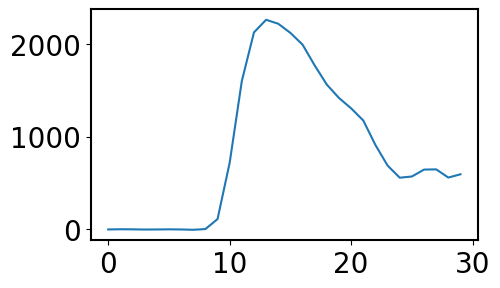

In [136]:
plt.figure(figsize=(5,3))
plt.plot(res);

#### CAVI

In [26]:
def cavi(s, y_k, means, covs, K, T, C, D, k_idxs, t_idxs, max_iter=20, eps=1e-10):
    
    # initialize
    r = torch.ones((s.shape[0], C)) / C
    mu, cov = torch.tensor(means), torch.tensor(covs)
    b = torch.normal(0, 1, size=(C,))
    beta = torch.normal(0, 1, size=(C,T,T))

    log_lam = torch.zeros((K, C, T))
    for k in range(K):
        for t in range(T):
            log_lam[k,:,t] = b + beta[:,t] @ y_k[k]

    log_norm_lam = log_lam - torch.logsumexp(log_lam, 1)[:,None,:]
    
    # compute ELBO
    elbo, log_dens = compute_elbo(s, r, mu, cov, log_norm_lam, k_idxs, t_idxs, K, T, C)
    convergence = 1.
    elbos = [elbo]
    print(f'initial elbo: {elbos[-1]:.2f}')
    
    it = 1
    while convergence > eps or convergence < 0:  # while ELBO not converged  
        
        b = b.requires_grad_(True)
        
        # update q(z)
        # r_{ijt}^k = rho_{ijt}^k / sum_j rho_{ijt}^k
        # rho_{ijt}^k = exp( log(dN(s_i^kt; mu_j, cov_j)) + 
        #                      ( log(lambda_jt^(k)) - log(sum_j' lambda_j't^(k)) ) )   
        for k in range(K):
            for t in range(T):
                k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
                r[k_t_idx] = torch.exp(log_dens[k_t_idx] + log_norm_lam[k,:,t])
                r[k_t_idx] = torch.einsum('ij,i->ij', r[k_t_idx], 1/r[k_t_idx].sum(1))
            
            
        # update b 
        b_new = torch.zeros_like(b)
        for j in range(C):
            b_new[j] = newton_bj(j, b, beta, y_k, r, k_idxs, t_idxs)
        b = b_new.clone().requires_grad_(False)
            
            
        # update beta
        beta_new = torch.zeros_like(beta)
        for j in range(C):
            no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
            for t in range(T):
                for l in range(T):
                    no_l = torch.cat([torch.arange(l), torch.arange(l+1,len(t_idxs))])
                    
                    inputs = ( j, t, l, 
                               beta[j,t,no_l].detach().numpy(), 
                               beta[no_j][:,t].detach().numpy(),
                               b.detach().numpy(), 
                               y_k.detach().numpy(), 
                               r.detach().numpy(), 
                               k_idxs, t_idxs
                              )
                    sol = optimize.root(safe_grad_beta_jtl, beta[j,t,l].detach().numpy(), 
                                                    args = inputs, method='lm')
                    beta_new[j,t,l] = sol.x[0]
                    res = sol.fun
                    counter = 0
                    init_guess = sol.x[0] - (2*sol.x[0])
                    while not np.allclose(res, 0): 
                        init_guess += sol.x[0] / 10.
                        sol = optimize.root(safe_grad_beta_jtl, init_guess, args = inputs, method='lm')
                        beta_new[j,t,l] = sol.x[0]
                        res = sol.fun.item()
                        counter += 1
                    if np.logical_and((t+1) % 1 == 0, (l+1) % 1 == 0):
                        print(f'grad at beta (j = {j}, t = {t}, l = {l}) : {beta_new[j,t,l]:.2f} is {res:.2f}.')
        beta = beta_new.clone()
        
        
        # compute lambda's
        log_lam = torch.zeros((K, C, T))
        for k in range(K):
            for t in range(T):
                log_lam[k,:,t] = b + beta[:,t] @ y_k[k]

        log_norm_lam = log_lam - torch.logsumexp(log_lam, 1)[:,None,:]
        
        
        # update means and covs
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] 
            ) for j in range(C)]
        
        # compute ELBO
        elbo, log_dens = compute_elbo(s, r, mu, cov, log_norm_lam, k_idxs, t_idxs, K, T, C)
        elbos.append(elbo)
        convergence = elbos[-1] - elbos[-2]
        
        print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
        it +=1 
        if it > max_iter: 
            print('reached max iter allowed.')
            break
            
    if abs(convergence) <= eps:
        print('converged.')
    
    return r, log_lam, log_norm_lam, b, beta, mu, cov, elbos

### Run

In [27]:
%%time
enc_r, enc_lam, enc_b, enc_beta, enc_mu, enc_cov, enc_elbo = cavi(
                                                    s=s, 
                                                    y_k=torch.tensor(data_loader.y_train), 
                                                    means=gmm.means_, 
                                                    covs=gmm.covariances_, 
                                                    K=K, 
                                                    T=T, 
                                                    C=C, 
                                                    D=train_trials.shape[1], 
                                                    k_idxs=train_k_ids,
                                                    t_idxs=train_t_ids, 
                                                    max_iter=1)

elbo 1: -115223206.2406357
elbo 2: -8201607.994920854
elbo 3: 1368129.286682262
initial elbo: -122056684.95
grad at b_0 = 19.41 is 108503.64
grad at b_0 = 68.98 is 0.62
grad at b_0 = 79.00 is 0.00
grad at b_0 = 82.00 is 0.00
grad at b_1 = 48.58 is 73197.92
grad at b_1 = 100.03 is 0.00
grad at b_1 = 106.03 is 0.00
grad at b_2 = 18.57 is 44286.00
grad at b_2 = 65.19 is 0.01
grad at b_2 = 73.32 is 0.00
grad at b_3 = 21.73 is 43860.51
grad at b_3 = 64.63 is 0.05
grad at b_3 = 74.66 is 0.00
grad at b_3 = 74.66 is 0.00
grad at b_4 = 26.18 is 34730.24
grad at b_4 = 86.54 is 0.00
grad at b_4 = 92.54 is 0.00
grad at b_5 = 15.12 is 38133.05
grad at b_5 = 50.80 is 0.21
grad at b_5 = 64.87 is 0.00
grad at b_5 = 66.93 is 0.00
grad at b_6 = 22.75 is 30082.46
grad at b_6 = 95.20 is 0.03
grad at b_6 = 105.20 is 0.00
grad at b_6 = 105.20 is 0.00
grad at b_7 = 15.54 is 34362.33
grad at b_7 = 62.79 is 0.14
grad at b_7 = 74.01 is 0.00
grad at b_7 = 75.04 is 0.00
grad at b_8 = 14.66 is 25898.12
grad at b_8

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(enc_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

f1 = ax1.imshow(enc_lam[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title(f'left')
ax1.set_xlabel('time')
ax1.set_ylabel('component')
fig.colorbar(f1, ax = ax1)

f2 = ax2.imshow(enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title(f'right')
ax2.set_xlabel('time')
fig.colorbar(f2, ax = ax2)

f3 = ax3.imshow(enc_lam[:,:,0] - enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('left - right')
ax3.set_xlabel('time')
fig.colorbar(f3, ax = ax3)

plt.tight_layout()